In [1]:
import torch
import gc
torch.cuda.empty_cache()
gc.collect()
from setup import setup_src_path
print(setup_src_path())
import data.processed as processed
import config.config as config
import utils.setup as setup
import utils.functions as fn
from importlib import reload



['/home/guest/Desktop/projects/third-experiments/SDA_experiments/mlm', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/guest/.cache/pypoetry/virtualenvs/third-experments-xuKQSur9-py3.8/lib/python3.8/site-packages', '/home/guest/Desktop/projects/third-experiments/SDA_experiments/modules']


2024-06-25 08:04:44.416634: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-25 08:04:44.596490: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 08:04:45.439507: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from datasets import load_from_disk, DatasetDict
from sklearn.model_selection import train_test_split

def load_and_prepare_datasets(source_genre, target_genre, data_fraction=0.01):
    # Load the dataset
    dataset = load_from_disk(f"{config.Config.DATASETS_SAVE_PATH}/SDA_cleaned")
    
    # Shuffle the source dataset
    filtered_source = dataset[source_genre].shuffle(seed=42)
    
    # If a fraction of the data is to be used
    if data_fraction < 1.0:
        filtered_source = filtered_source.select(range(int(len(filtered_source) * data_fraction)))
    
    # Split the source dataset into 80% train and 20% remaining
    train_size = 0.8
    source_train_dataset, source_remaining_dataset = filtered_source.train_test_split(test_size=1-train_size, seed=42).values()
     
    # Combine source splits into a DatasetDict
    source_dataset_dict = DatasetDict({
        'train': source_train_dataset,
        'val': source_remaining_dataset
    })
    
    # Shuffle the target dataset
    filtered_target = dataset[target_genre].shuffle(seed=42)
    
    # If a fraction of the data is to be used
    if data_fraction < 1.0:
        filtered_target = filtered_target.select(range(int(len(filtered_target) * data_fraction)))
    
    # Split the target dataset into 80% train and 20% remaining
    target_train_dataset, target_remaining_dataset = filtered_target.train_test_split(test_size=1-train_size, seed=42).values()
    
      
    # Combine target splits into a DatasetDict
    target_dataset_dict = DatasetDict({
        'train': target_train_dataset,
        'test': target_remaining_dataset,
    })
    
    # Print the number of examples in each split to verify
    print(f"Source Train dataset size: {len(source_dataset_dict['train'])}")
    print(f"Source Validation dataset size: {len(source_dataset_dict['val'])}")
    
    print(f"Target Train dataset size: {len(target_dataset_dict['train'])}")
    print(f"Target Test dataset size: {len(target_dataset_dict['test'])}")
    
    return source_dataset_dict, target_dataset_dict

# Example usage
source_genre = 'books'
target_genre = 'electronics'
source_dataset, target_dataset = load_and_prepare_datasets(source_genre, target_genre, data_fraction=1)


Source Train dataset size: 1600
Source Validation dataset size: 400
Target Train dataset size: 1600
Target Test dataset size: 400


In [3]:
import torch
import numpy as np
import random
from datasets import load_from_disk, concatenate_datasets
from transformers import AutoTokenizer,Trainer, AutoConfig, TrainingArguments, EvalPrediction,BertForSequenceClassification, default_data_collator, EarlyStoppingCallback, get_cosine_schedule_with_warmup
from adapters import AdapterTrainer, AutoAdapterModel, AdapterConfig, composition
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from pprint import pprint
def set_seeds(seed=42):
    print(f"===============================================")
    print(f"Setting seed to: {seed}")
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


def tokenize_dataset(data, tokenizer):
    def tokenize_function(examples):
        result = tokenizer(examples['review'], truncation=True, padding='max_length', max_length=128)
        # if tokenizer.is_fast:
        #     result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
        return result

    tokenized_datasets = data.map(tokenize_function, batched=True)
    tokenized_datasets = tokenized_datasets.remove_columns(
        ['review']
    ).rename_column("label", "labels").with_format('torch')

    return tokenized_datasets

def prepare_model(adapter_name, mlm_adapter):
    mdlcfg = AutoConfig.from_pretrained(config.Config.MODEL_NAME,num_labels=2)
    model = BertForSequenceClassification.from_pretrained(config.Config.MODEL_NAME, config=mdlcfg)
    adapter_config = AdapterConfig.load("lora", r=8, alpha=16)

    #model.add_adapter(adapter_name, config=adapter_config)
    #model.load_adapter(f"{config.Config.ADAPTER_SAVE_PATH}/{mlm_adapter}", with_head=False)
    #model.add_classification_head(adapter_name, num_labels=2)
    #model.active_adapters = composition.Stack(mlm_adapter, adapter_name)
    #model.train_adapter(composition.Stack(mlm_adapter, adapter_name))
    #print(model.adapter_summary())
    fn.print_trainable_parameters(model)
    return model

def plot_confusion_matrix(labels, preds, classes):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(4, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def compute_metrics(pred: EvalPrediction):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    
    # Plot confusion matrix
    plot_confusion_matrix(labels, preds, classes=['class_0', 'class_1'])
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }



def train_and_evaluate(project_name,seed, train_source, train_target, source_genre, target_genre, adapter_name, mlm_adapter):
    set_seeds(seed)
    
    wandb.init(project=f"{project_name}", name=f"{source_genre}_{target_genre}_run_seed_{seed}")

    tokenizer = AutoTokenizer.from_pretrained(config.Config.TOKENIZER_NAME)

    tokenized_source_dataset = tokenize_dataset(train_source, tokenizer)
    tokenized_target_dataset = tokenize_dataset(train_target, tokenizer)

    train_source, val_source = tokenized_source_dataset['train'], tokenized_source_dataset['val']
    train_target, test_target= tokenized_target_dataset['train'], tokenized_target_dataset['test']
    

    model = prepare_model(adapter_name, mlm_adapter)

    eval_data = val_source
    batch_size = 16
    logging_steps = len(train_source) // (batch_size * 2)

    training_args = TrainingArguments(
        output_dir=f"{config.Config.RESULTS_SAVE_PATH}/{adapter_name}/results",
        num_train_epochs=10,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=500,
        learning_rate=1e-4,
        weight_decay=0.01,
        logging_dir=f"{config.Config.RESULTS_SAVE_PATH}/{adapter_name}/logs",
        logging_steps=logging_steps,
        evaluation_strategy="steps",
        eval_steps=logging_steps,
        save_steps=logging_steps,
        save_total_limit=2,
        #load_best_model_at_end=True,
        #metric_for_best_model="eval_accuracy",
        #greater_is_better=True,                
        report_to="wandb"
    )

    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_source,
        eval_dataset=eval_data,
        #callbacks=callbacks,
        compute_metrics=compute_metrics
    )

    trainer.create_optimizer_and_scheduler(num_training_steps=len(train_source) * training_args.num_train_epochs // batch_size)
    optimizer = trainer.optimizer
    total_steps = len(train_source) * training_args.num_train_epochs // batch_size
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=training_args.warmup_steps, num_training_steps=total_steps)
    trainer.lr_scheduler = scheduler

    trainer.train()
    eval_trainer = Trainer(
        model=model,
        args=TrainingArguments(f"{config.Config.RESULTS_SAVE_PATH}/{adapter_name}/results", remove_unused_columns=False),
        eval_dataset=val_source,
        compute_metrics=compute_metrics,
    )
    eval_results = eval_trainer.evaluate()
    wandb.log({"eval_results": eval_results})
    # Evaluate on test set
    test_results = eval_trainer.evaluate(eval_dataset=test_target)
    plot_loss(trainer.state.log_history)

    #wandb.log(eval_results)
    wandb.log({"test_results": test_results})
    
    wandb.finish()

    return eval_results,test_results

def plot_loss(log_history):
    epochs_train = []
    training_losses = []
    epochs_eval = []
    evaluation_losses = []

    for record in log_history:
        if "loss" in record and "epoch" in record:
            epochs_train.append(record["epoch"])
            training_losses.append(record["loss"])
        if "eval_loss" in record and "epoch" in record:
            epochs_eval.append(record["epoch"])
            evaluation_losses.append(record["eval_loss"])

    plt.figure(figsize=(6, 3))
    plt.plot(epochs_train, training_losses, 'b', label='Training Loss')
    plt.plot(epochs_eval, evaluation_losses, 'r', label='Evaluation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Evaluation Loss over Epochs')
    plt.legend()
    plt.show()


    

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Source Train dataset size: 1600
Source Validation dataset size: 400
Target Train dataset size: 1600
Target Test dataset size: 400
Setting seed to: 42


wandb: Currently logged in as: mrawhani5 (mrawhani). Use `wandb login --relogin` to force relogin


/home/guest/.cache/pypoetry/virtualenvs/third-experments-xuKQSur9-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/guest/.cache/pypoetry/virtualenvs/third-experments-xuKQSur9-py3.8/lib/python3.8/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an

trainable params: 109483778 || all params: 109483778 || trainable%: 100.0


  0%|          | 0/1000 [00:00<?, ?it/s]

{'loss': 0.6822, 'grad_norm': 5.3969926834106445, 'learning_rate': 1e-05, 'epoch': 0.5}


  0%|          | 0/25 [00:00<?, ?it/s]

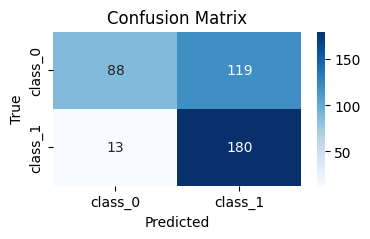

{'eval_loss': 0.6335818767547607, 'eval_accuracy': 0.67, 'eval_f1': 0.6487630662020907, 'eval_precision': 0.7413593165336602, 'eval_recall': 0.67, 'eval_runtime': 1.2277, 'eval_samples_per_second': 325.803, 'eval_steps_per_second': 20.363, 'epoch': 0.5}
{'loss': 0.499, 'grad_norm': 5.638792991638184, 'learning_rate': 2e-05, 'epoch': 1.0}


  0%|          | 0/25 [00:00<?, ?it/s]

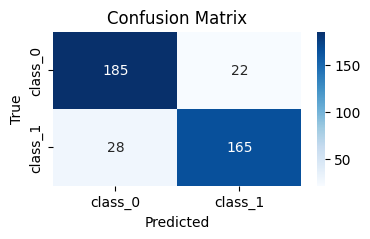

{'eval_loss': 0.3364260494709015, 'eval_accuracy': 0.875, 'eval_f1': 0.874906015037594, 'eval_precision': 0.8752071251035625, 'eval_recall': 0.875, 'eval_runtime': 1.2359, 'eval_samples_per_second': 323.66, 'eval_steps_per_second': 20.229, 'epoch': 1.0}
{'loss': 0.3212, 'grad_norm': 11.121386528015137, 'learning_rate': 3e-05, 'epoch': 1.5}


  0%|          | 0/25 [00:00<?, ?it/s]

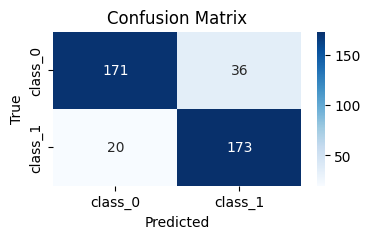

{'eval_loss': 0.3304118812084198, 'eval_accuracy': 0.86, 'eval_f1': 0.8599719992999826, 'eval_precision': 0.8627014704777173, 'eval_recall': 0.86, 'eval_runtime': 1.2135, 'eval_samples_per_second': 329.634, 'eval_steps_per_second': 20.602, 'epoch': 1.5}
{'loss': 0.3349, 'grad_norm': 14.834526062011719, 'learning_rate': 4e-05, 'epoch': 2.0}


  0%|          | 0/25 [00:00<?, ?it/s]

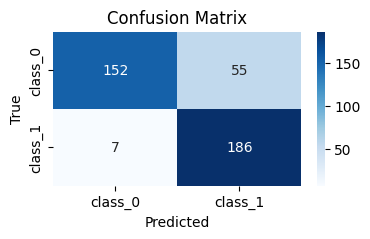

{'eval_loss': 0.41887328028678894, 'eval_accuracy': 0.845, 'eval_f1': 0.843407494145199, 'eval_precision': 0.867102873248258, 'eval_recall': 0.845, 'eval_runtime': 1.2088, 'eval_samples_per_second': 330.902, 'eval_steps_per_second': 20.681, 'epoch': 2.0}
{'loss': 0.203, 'grad_norm': 24.264741897583008, 'learning_rate': 5e-05, 'epoch': 2.5}


  0%|          | 0/25 [00:00<?, ?it/s]

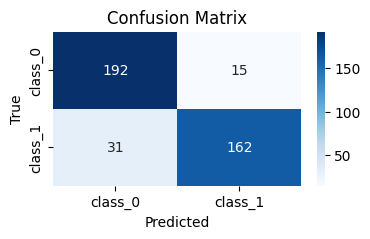

{'eval_loss': 0.37260550260543823, 'eval_accuracy': 0.885, 'eval_f1': 0.8846530483972345, 'eval_precision': 0.8871707076081173, 'eval_recall': 0.885, 'eval_runtime': 1.2119, 'eval_samples_per_second': 330.057, 'eval_steps_per_second': 20.629, 'epoch': 2.5}
{'loss': 0.251, 'grad_norm': 10.9082670211792, 'learning_rate': 6e-05, 'epoch': 3.0}


  0%|          | 0/25 [00:00<?, ?it/s]

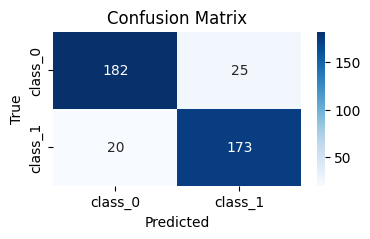

{'eval_loss': 0.34713858366012573, 'eval_accuracy': 0.8875, 'eval_f1': 0.8875316566511796, 'eval_precision': 0.8878406590659066, 'eval_recall': 0.8875, 'eval_runtime': 1.2092, 'eval_samples_per_second': 330.786, 'eval_steps_per_second': 20.674, 'epoch': 3.0}
{'loss': 0.1689, 'grad_norm': 0.8619623780250549, 'learning_rate': 7e-05, 'epoch': 3.5}


  0%|          | 0/25 [00:00<?, ?it/s]

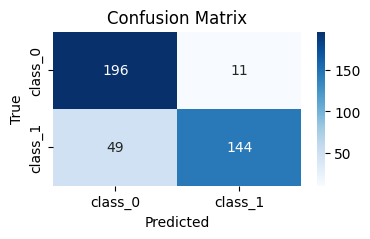

{'eval_loss': 0.455098420381546, 'eval_accuracy': 0.85, 'eval_f1': 0.8481156545620995, 'eval_precision': 0.8622580645161291, 'eval_recall': 0.85, 'eval_runtime': 1.2482, 'eval_samples_per_second': 320.452, 'eval_steps_per_second': 20.028, 'epoch': 3.5}
{'loss': 0.177, 'grad_norm': 6.698533535003662, 'learning_rate': 8e-05, 'epoch': 4.0}


  0%|          | 0/25 [00:00<?, ?it/s]

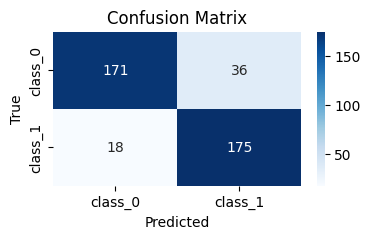

{'eval_loss': 0.36863890290260315, 'eval_accuracy': 0.865, 'eval_f1': 0.8649392439243926, 'eval_precision': 0.8683920108327692, 'eval_recall': 0.865, 'eval_runtime': 1.2202, 'eval_samples_per_second': 327.806, 'eval_steps_per_second': 20.488, 'epoch': 4.0}
{'loss': 0.0663, 'grad_norm': 0.09569957107305527, 'learning_rate': 9e-05, 'epoch': 4.5}


  0%|          | 0/25 [00:00<?, ?it/s]

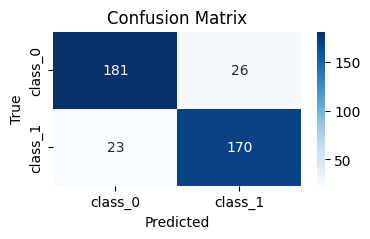

{'eval_loss': 0.6664742827415466, 'eval_accuracy': 0.8775, 'eval_f1': 0.8775252847465896, 'eval_precision': 0.8776493097238895, 'eval_recall': 0.8775, 'eval_runtime': 1.2273, 'eval_samples_per_second': 325.925, 'eval_steps_per_second': 20.37, 'epoch': 4.5}
{'loss': 0.2398, 'grad_norm': 19.300973892211914, 'learning_rate': 0.0001, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

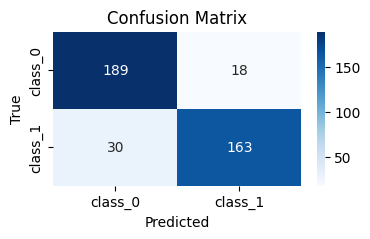

{'eval_loss': 0.5010861158370972, 'eval_accuracy': 0.88, 'eval_f1': 0.8797650071552309, 'eval_precision': 0.8811261636267312, 'eval_recall': 0.88, 'eval_runtime': 1.2304, 'eval_samples_per_second': 325.108, 'eval_steps_per_second': 20.319, 'epoch': 5.0}
{'loss': 0.1695, 'grad_norm': 0.1711704581975937, 'learning_rate': 9e-05, 'epoch': 5.5}


  0%|          | 0/25 [00:00<?, ?it/s]

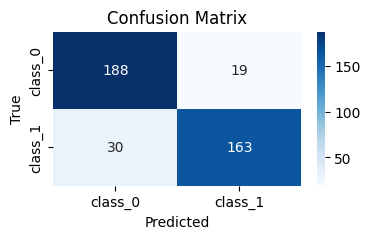

{'eval_loss': 0.5638617277145386, 'eval_accuracy': 0.8775, 'eval_f1': 0.8772886274509805, 'eval_precision': 0.8784135245488457, 'eval_recall': 0.8775, 'eval_runtime': 1.2089, 'eval_samples_per_second': 330.889, 'eval_steps_per_second': 20.681, 'epoch': 5.5}
{'loss': 0.0917, 'grad_norm': 0.09017381817102432, 'learning_rate': 8e-05, 'epoch': 6.0}


  0%|          | 0/25 [00:00<?, ?it/s]

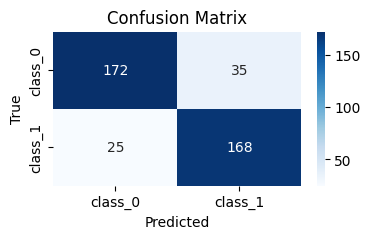

{'eval_loss': 0.7407184839248657, 'eval_accuracy': 0.85, 'eval_f1': 0.850037503750375, 'eval_precision': 0.8511377559950989, 'eval_recall': 0.85, 'eval_runtime': 1.2087, 'eval_samples_per_second': 330.927, 'eval_steps_per_second': 20.683, 'epoch': 6.0}
{'loss': 0.0351, 'grad_norm': 0.02502257190644741, 'learning_rate': 7e-05, 'epoch': 6.5}


  0%|          | 0/25 [00:00<?, ?it/s]

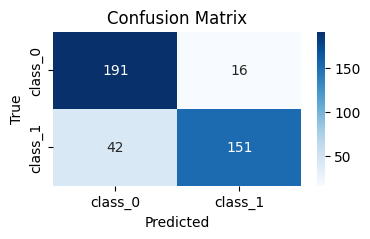

{'eval_loss': 0.8396480083465576, 'eval_accuracy': 0.855, 'eval_f1': 0.8540479797979799, 'eval_precision': 0.8604891932872453, 'eval_recall': 0.855, 'eval_runtime': 1.2712, 'eval_samples_per_second': 314.672, 'eval_steps_per_second': 19.667, 'epoch': 6.5}
{'loss': 0.1176, 'grad_norm': 0.08231230825185776, 'learning_rate': 6e-05, 'epoch': 7.0}


  0%|          | 0/25 [00:00<?, ?it/s]

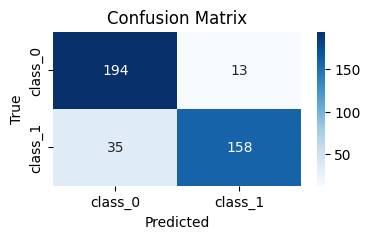

{'eval_loss': 0.5939508080482483, 'eval_accuracy': 0.88, 'eval_f1': 0.879401149309406, 'eval_precision': 0.8842248269874102, 'eval_recall': 0.88, 'eval_runtime': 1.2132, 'eval_samples_per_second': 329.706, 'eval_steps_per_second': 20.607, 'epoch': 7.0}
{'loss': 0.0447, 'grad_norm': 0.09961424022912979, 'learning_rate': 5e-05, 'epoch': 7.5}


  0%|          | 0/25 [00:00<?, ?it/s]

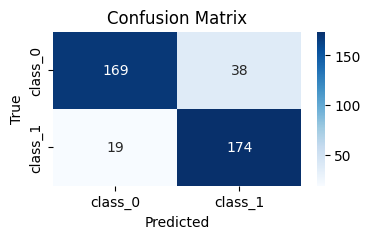

{'eval_loss': 0.7577862739562988, 'eval_accuracy': 0.8575, 'eval_f1': 0.8574153774027192, 'eval_precision': 0.8612136190285026, 'eval_recall': 0.8575, 'eval_runtime': 1.2207, 'eval_samples_per_second': 327.668, 'eval_steps_per_second': 20.479, 'epoch': 7.5}
{'loss': 0.0111, 'grad_norm': 0.13909809291362762, 'learning_rate': 4e-05, 'epoch': 8.0}


  0%|          | 0/25 [00:00<?, ?it/s]

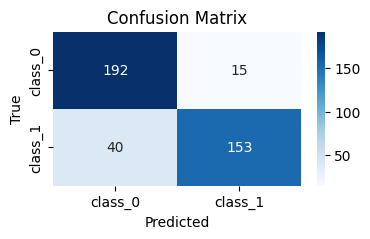

{'eval_loss': 0.8501254916191101, 'eval_accuracy': 0.8625, 'eval_f1': 0.8616540677313713, 'eval_precision': 0.8676955049261084, 'eval_recall': 0.8625, 'eval_runtime': 1.2325, 'eval_samples_per_second': 324.551, 'eval_steps_per_second': 20.284, 'epoch': 8.0}
{'loss': 0.014, 'grad_norm': 0.017751449719071388, 'learning_rate': 3e-05, 'epoch': 8.5}


  0%|          | 0/25 [00:00<?, ?it/s]

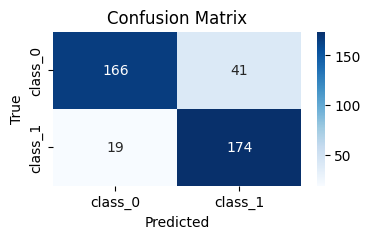

{'eval_loss': 0.9850071668624878, 'eval_accuracy': 0.85, 'eval_f1': 0.8498349339735892, 'eval_precision': 0.8548397234443746, 'eval_recall': 0.85, 'eval_runtime': 1.2502, 'eval_samples_per_second': 319.948, 'eval_steps_per_second': 19.997, 'epoch': 8.5}
{'loss': 0.0006, 'grad_norm': 0.006807427387684584, 'learning_rate': 2e-05, 'epoch': 9.0}


  0%|          | 0/25 [00:00<?, ?it/s]

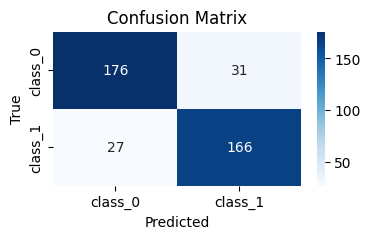

{'eval_loss': 0.9489779472351074, 'eval_accuracy': 0.855, 'eval_f1': 0.8550362726704189, 'eval_precision': 0.85524355479983, 'eval_recall': 0.855, 'eval_runtime': 1.2165, 'eval_samples_per_second': 328.801, 'eval_steps_per_second': 20.55, 'epoch': 9.0}
{'loss': 0.0008, 'grad_norm': 0.008231254294514656, 'learning_rate': 1e-05, 'epoch': 9.5}


  0%|          | 0/25 [00:00<?, ?it/s]

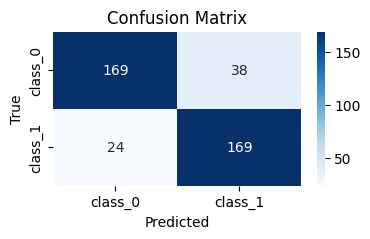

{'eval_loss': 1.0108869075775146, 'eval_accuracy': 0.845, 'eval_f1': 0.845, 'eval_precision': 0.8470727891667292, 'eval_recall': 0.845, 'eval_runtime': 1.2169, 'eval_samples_per_second': 328.703, 'eval_steps_per_second': 20.544, 'epoch': 9.5}
{'loss': 0.0002, 'grad_norm': 0.006663042586296797, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/25 [00:00<?, ?it/s]

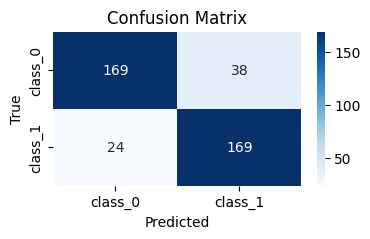

{'eval_loss': 1.0132949352264404, 'eval_accuracy': 0.845, 'eval_f1': 0.845, 'eval_precision': 0.8470727891667292, 'eval_recall': 0.845, 'eval_runtime': 1.2179, 'eval_samples_per_second': 328.438, 'eval_steps_per_second': 20.527, 'epoch': 10.0}
{'train_runtime': 197.0944, 'train_samples_per_second': 81.179, 'train_steps_per_second': 5.074, 'train_loss': 0.171429661013186, 'epoch': 10.0}


/home/guest/.cache/pypoetry/virtualenvs/third-experments-xuKQSur9-py3.8/lib/python3.8/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

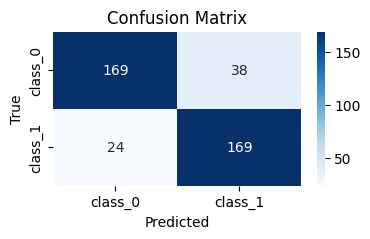

  0%|          | 0/50 [00:00<?, ?it/s]

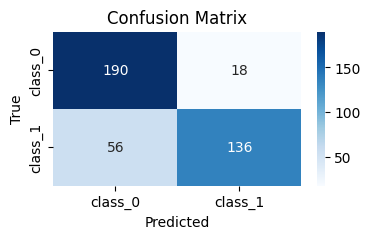

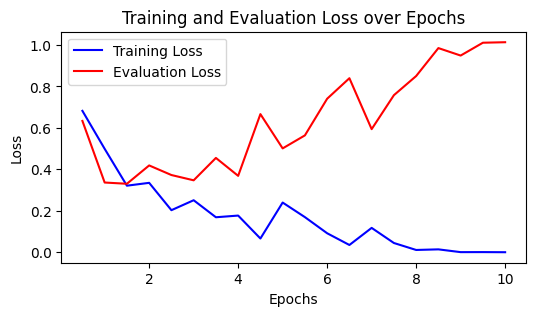

eval/accuracy,▁█▇▇██▇▇███▇▇█▇▇▇▇▇▇▇▆
eval/f1,▁█▇▇██▇▇███▇▇█▇▇▇▇▇▇▇▆
eval/loss,▃▁▁▂▁▁▂▁▄▂▃▄▅▃▄▅▆▆▇▇▇█
eval/precision,▁▇▇▇██▇▇███▆▇█▇▇▆▆▆▆▆▅
eval/recall,▁█▇▇██▇▇███▇▇█▇▇▇▇▇▇▇▆
eval/runtime,▂▂▁▁▁▁▂▁▂▂▁▁▃▁▁▂▃▁▁▁█▇
eval/samples_per_second,▇▇████▆█▇▇██▅█▇▇▆███▁▂
eval/steps_per_second,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████▁▁▁
train/grad_norm,▃▃▄▅█▄▁▃▁▇▁▁▁▁▁▁▁▁▁▁


Evaluation Results for seed 42:
{'eval_accuracy': 0.845,
 'eval_f1': 0.845,
 'eval_loss': 1.01329505443573,
 'eval_precision': 0.8470727891667292,
 'eval_recall': 0.845,
 'eval_runtime': 1.3989,
 'eval_samples_per_second': 285.947,
 'eval_steps_per_second': 35.743}
Test Results for seed 42:
{'eval_accuracy': 0.815,
 'eval_f1': 0.8125833312113264,
 'eval_loss': 1.190169095993042,
 'eval_precision': 0.8255221201562665,
 'eval_recall': 0.815,
 'eval_runtime': 1.3757,
 'eval_samples_per_second': 290.752,
 'eval_steps_per_second': 36.344}
Setting seed to: 10


/home/guest/.cache/pypoetry/virtualenvs/third-experments-xuKQSur9-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/guest/.cache/pypoetry/virtualenvs/third-experments-xuKQSur9-py3.8/lib/python3.8/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an

trainable params: 109483778 || all params: 109483778 || trainable%: 100.0


  0%|          | 0/1000 [00:00<?, ?it/s]

{'loss': 0.6917, 'grad_norm': 4.814345359802246, 'learning_rate': 1e-05, 'epoch': 0.5}


  0%|          | 0/25 [00:00<?, ?it/s]

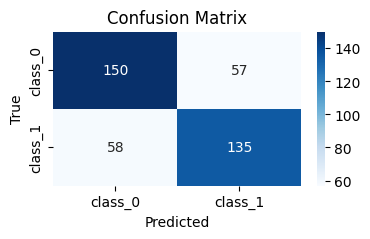

{'eval_loss': 0.6349831819534302, 'eval_accuracy': 0.7125, 'eval_f1': 0.7124730089187921, 'eval_precision': 0.7124549278846155, 'eval_recall': 0.7125, 'eval_runtime': 1.2258, 'eval_samples_per_second': 326.315, 'eval_steps_per_second': 20.395, 'epoch': 0.5}
{'loss': 0.5306, 'grad_norm': 5.013908863067627, 'learning_rate': 2e-05, 'epoch': 1.0}


  0%|          | 0/25 [00:00<?, ?it/s]

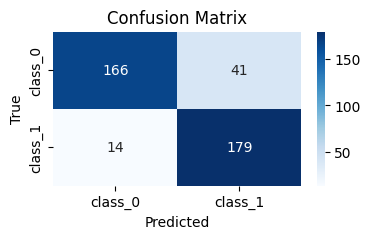

{'eval_loss': 0.35858970880508423, 'eval_accuracy': 0.8625, 'eval_f1': 0.8621980404302044, 'eval_precision': 0.8698295454545455, 'eval_recall': 0.8625, 'eval_runtime': 1.2301, 'eval_samples_per_second': 325.164, 'eval_steps_per_second': 20.323, 'epoch': 1.0}
{'loss': 0.3661, 'grad_norm': 12.188232421875, 'learning_rate': 3e-05, 'epoch': 1.5}


  0%|          | 0/25 [00:00<?, ?it/s]

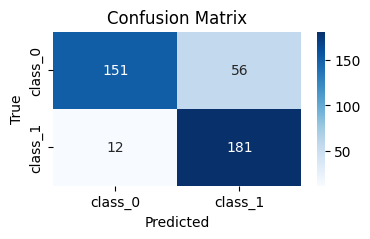

{'eval_loss': 0.4018796682357788, 'eval_accuracy': 0.83, 'eval_f1': 0.8285895663104965, 'eval_precision': 0.8478934016722321, 'eval_recall': 0.83, 'eval_runtime': 1.2148, 'eval_samples_per_second': 329.266, 'eval_steps_per_second': 20.579, 'epoch': 1.5}
{'loss': 0.298, 'grad_norm': 14.030220985412598, 'learning_rate': 4e-05, 'epoch': 2.0}


  0%|          | 0/25 [00:00<?, ?it/s]

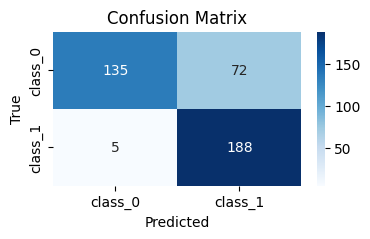

{'eval_loss': 0.41960427165031433, 'eval_accuracy': 0.8075, 'eval_f1': 0.8031513572660012, 'eval_precision': 0.8479024725274725, 'eval_recall': 0.8075, 'eval_runtime': 1.2161, 'eval_samples_per_second': 328.919, 'eval_steps_per_second': 20.557, 'epoch': 2.0}
{'loss': 0.2195, 'grad_norm': 26.36626434326172, 'learning_rate': 5e-05, 'epoch': 2.5}


  0%|          | 0/25 [00:00<?, ?it/s]

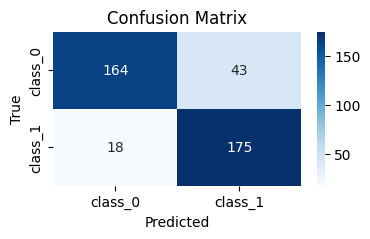

{'eval_loss': 0.5326898694038391, 'eval_accuracy': 0.8475, 'eval_f1': 0.8472376922547675, 'eval_precision': 0.8536466629700575, 'eval_recall': 0.8475, 'eval_runtime': 1.2661, 'eval_samples_per_second': 315.939, 'eval_steps_per_second': 19.746, 'epoch': 2.5}
{'loss': 0.2367, 'grad_norm': 6.627413749694824, 'learning_rate': 6e-05, 'epoch': 3.0}


  0%|          | 0/25 [00:00<?, ?it/s]

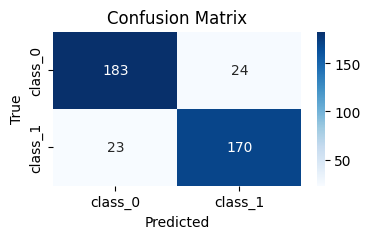

{'eval_loss': 0.3245214819908142, 'eval_accuracy': 0.8825, 'eval_f1': 0.882509556969549, 'eval_precision': 0.8825301521369232, 'eval_recall': 0.8825, 'eval_runtime': 1.2312, 'eval_samples_per_second': 324.889, 'eval_steps_per_second': 20.306, 'epoch': 3.0}
{'loss': 0.1485, 'grad_norm': 0.2950642704963684, 'learning_rate': 7e-05, 'epoch': 3.5}


  0%|          | 0/25 [00:00<?, ?it/s]

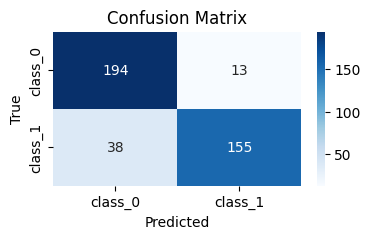

{'eval_loss': 0.5517717599868774, 'eval_accuracy': 0.8725, 'eval_f1': 0.8717155900781808, 'eval_precision': 0.8779007594417078, 'eval_recall': 0.8725, 'eval_runtime': 1.2299, 'eval_samples_per_second': 325.218, 'eval_steps_per_second': 20.326, 'epoch': 3.5}
{'loss': 0.2268, 'grad_norm': 23.798274993896484, 'learning_rate': 8e-05, 'epoch': 4.0}


  0%|          | 0/25 [00:00<?, ?it/s]

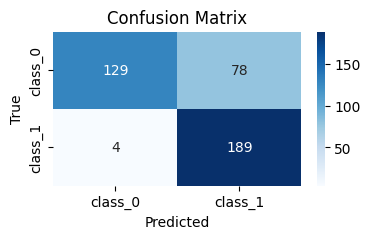

{'eval_loss': 0.6586470603942871, 'eval_accuracy': 0.795, 'eval_f1': 0.7891803069053708, 'eval_precision': 0.8434810340457887, 'eval_recall': 0.795, 'eval_runtime': 1.2417, 'eval_samples_per_second': 322.134, 'eval_steps_per_second': 20.133, 'epoch': 4.0}
{'loss': 0.2396, 'grad_norm': 0.3976147174835205, 'learning_rate': 9e-05, 'epoch': 4.5}


  0%|          | 0/25 [00:00<?, ?it/s]

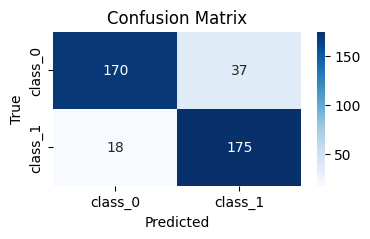

{'eval_loss': 0.4919932186603546, 'eval_accuracy': 0.8625, 'eval_f1': 0.8624183466166587, 'eval_precision': 0.8662422219991971, 'eval_recall': 0.8625, 'eval_runtime': 1.232, 'eval_samples_per_second': 324.68, 'eval_steps_per_second': 20.292, 'epoch': 4.5}
{'loss': 0.1616, 'grad_norm': 9.15639591217041, 'learning_rate': 0.0001, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

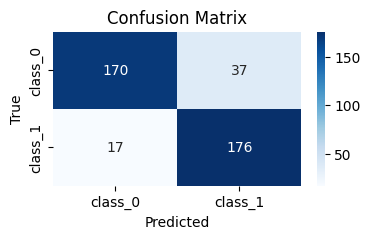

{'eval_loss': 0.5267228484153748, 'eval_accuracy': 0.865, 'eval_f1': 0.864898727213623, 'eval_precision': 0.8691399914639351, 'eval_recall': 0.865, 'eval_runtime': 1.2427, 'eval_samples_per_second': 321.87, 'eval_steps_per_second': 20.117, 'epoch': 5.0}
{'loss': 0.1338, 'grad_norm': 0.140634685754776, 'learning_rate': 9e-05, 'epoch': 5.5}


  0%|          | 0/25 [00:00<?, ?it/s]

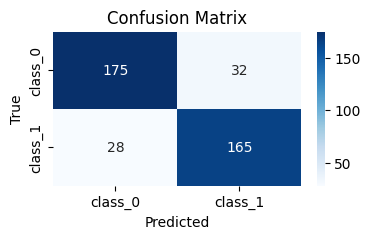

{'eval_loss': 0.660292387008667, 'eval_accuracy': 0.85, 'eval_f1': 0.8500375234521576, 'eval_precision': 0.8502450551374059, 'eval_recall': 0.85, 'eval_runtime': 1.2276, 'eval_samples_per_second': 325.834, 'eval_steps_per_second': 20.365, 'epoch': 5.5}
{'loss': 0.0651, 'grad_norm': 45.63003158569336, 'learning_rate': 8e-05, 'epoch': 6.0}


  0%|          | 0/25 [00:00<?, ?it/s]

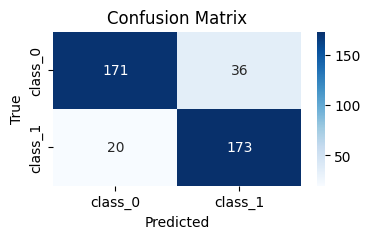

{'eval_loss': 0.7288646101951599, 'eval_accuracy': 0.86, 'eval_f1': 0.8599719992999826, 'eval_precision': 0.8627014704777173, 'eval_recall': 0.86, 'eval_runtime': 1.2429, 'eval_samples_per_second': 321.829, 'eval_steps_per_second': 20.114, 'epoch': 6.0}
{'loss': 0.0598, 'grad_norm': 2.200669288635254, 'learning_rate': 7e-05, 'epoch': 6.5}


  0%|          | 0/25 [00:00<?, ?it/s]

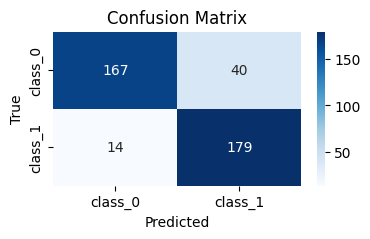

{'eval_loss': 0.8621292114257812, 'eval_accuracy': 0.865, 'eval_f1': 0.8647365128615755, 'eval_precision': 0.871844521809329, 'eval_recall': 0.865, 'eval_runtime': 1.22, 'eval_samples_per_second': 327.865, 'eval_steps_per_second': 20.492, 'epoch': 6.5}
{'loss': 0.0726, 'grad_norm': 0.030213920399546623, 'learning_rate': 6e-05, 'epoch': 7.0}


  0%|          | 0/25 [00:00<?, ?it/s]

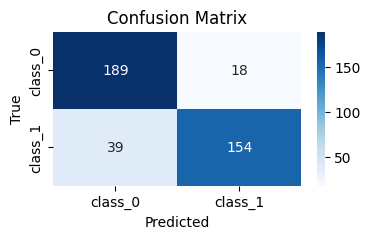

{'eval_loss': 0.7176854014396667, 'eval_accuracy': 0.8575, 'eval_f1': 0.8568403401039205, 'eval_precision': 0.8609860771113831, 'eval_recall': 0.8575, 'eval_runtime': 1.2341, 'eval_samples_per_second': 324.121, 'eval_steps_per_second': 20.258, 'epoch': 7.0}
{'loss': 0.0316, 'grad_norm': 0.016158821061253548, 'learning_rate': 5e-05, 'epoch': 7.5}


  0%|          | 0/25 [00:00<?, ?it/s]

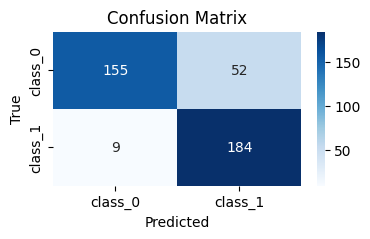

{'eval_loss': 0.920653223991394, 'eval_accuracy': 0.8475, 'eval_f1': 0.8463051728146067, 'eval_precision': 0.8652870504340636, 'eval_recall': 0.8475, 'eval_runtime': 1.2491, 'eval_samples_per_second': 320.228, 'eval_steps_per_second': 20.014, 'epoch': 7.5}
{'loss': 0.0242, 'grad_norm': 0.01387186348438263, 'learning_rate': 4e-05, 'epoch': 8.0}


  0%|          | 0/25 [00:00<?, ?it/s]

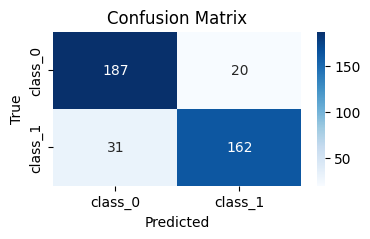

{'eval_loss': 0.788418710231781, 'eval_accuracy': 0.8725, 'eval_f1': 0.87228, 'eval_precision': 0.8733885724367376, 'eval_recall': 0.8725, 'eval_runtime': 1.2417, 'eval_samples_per_second': 322.13, 'eval_steps_per_second': 20.133, 'epoch': 8.0}
{'loss': 0.0004, 'grad_norm': 0.008547653444111347, 'learning_rate': 3e-05, 'epoch': 8.5}


  0%|          | 0/25 [00:00<?, ?it/s]

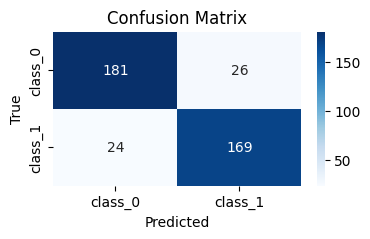

{'eval_loss': 0.7962350249290466, 'eval_accuracy': 0.875, 'eval_f1': 0.8750187668902012, 'eval_precision': 0.8750813008130082, 'eval_recall': 0.875, 'eval_runtime': 1.213, 'eval_samples_per_second': 329.751, 'eval_steps_per_second': 20.609, 'epoch': 8.5}
{'loss': 0.0075, 'grad_norm': 0.008750519715249538, 'learning_rate': 2e-05, 'epoch': 9.0}


  0%|          | 0/25 [00:00<?, ?it/s]

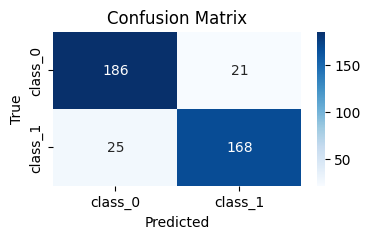

{'eval_loss': 0.8020368814468384, 'eval_accuracy': 0.885, 'eval_f1': 0.8849481449936121, 'eval_precision': 0.8850737230121116, 'eval_recall': 0.885, 'eval_runtime': 1.2263, 'eval_samples_per_second': 326.173, 'eval_steps_per_second': 20.386, 'epoch': 9.0}
{'loss': 0.0031, 'grad_norm': 0.005845775827765465, 'learning_rate': 1e-05, 'epoch': 9.5}


  0%|          | 0/25 [00:00<?, ?it/s]

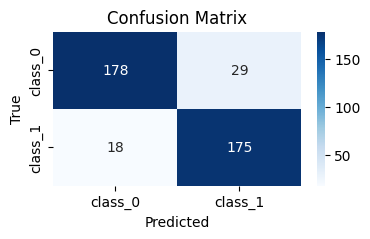

{'eval_loss': 0.8132238984107971, 'eval_accuracy': 0.8825, 'eval_f1': 0.8825242357382603, 'eval_precision': 0.8838838035214086, 'eval_recall': 0.8825, 'eval_runtime': 2.1207, 'eval_samples_per_second': 188.615, 'eval_steps_per_second': 11.788, 'epoch': 9.5}
{'loss': 0.0033, 'grad_norm': 0.005278289783746004, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/25 [00:00<?, ?it/s]

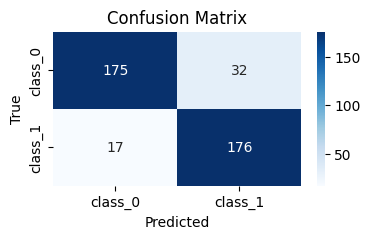

{'eval_loss': 0.8285028338432312, 'eval_accuracy': 0.8775, 'eval_f1': 0.8774885155532224, 'eval_precision': 0.8799489182692306, 'eval_recall': 0.8775, 'eval_runtime': 2.2959, 'eval_samples_per_second': 174.22, 'eval_steps_per_second': 10.889, 'epoch': 10.0}
{'train_runtime': 206.5326, 'train_samples_per_second': 77.47, 'train_steps_per_second': 4.842, 'train_loss': 0.1760295398272574, 'epoch': 10.0}


/home/guest/.cache/pypoetry/virtualenvs/third-experments-xuKQSur9-py3.8/lib/python3.8/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

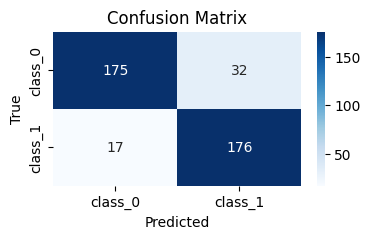

  0%|          | 0/50 [00:00<?, ?it/s]

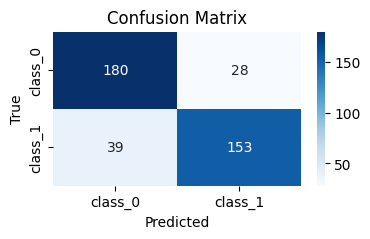

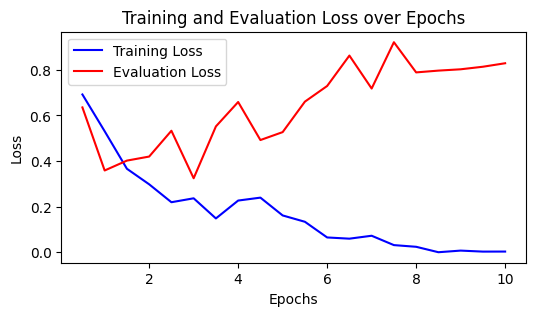

eval/accuracy,▁▇▆▅▆█▇▄▇▇▇▇▇▇▆▇█████▆
eval/f1,▁▇▆▅▆█▇▄▇▇▇▇▇▇▆▇█████▆
eval/loss,▄▁▂▂▃▁▃▄▂▃▄▄▆▄▆▅▅▅▅▅▅█
eval/precision,▁▇▆▆▇██▆▇▇▇▇▇▇▇██████▆
eval/recall,▁▇▆▅▆█▇▄▇▇▇▇▇▇▆▇█████▆
eval/runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▆██
eval/samples_per_second,████▇█████████████▂▂▁▁
eval/steps_per_second,████▇█████████████▂▁▇▇
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████▁▁▁
train/grad_norm,▂▂▃▃▅▂▁▅▁▂▁█▁▁▁▁▁▁▁▁


Evaluation Results for seed 10:
{'eval_accuracy': 0.8775,
 'eval_f1': 0.8774885155532224,
 'eval_loss': 0.8285029530525208,
 'eval_precision': 0.8799489182692306,
 'eval_recall': 0.8775,
 'eval_runtime': 2.593,
 'eval_samples_per_second': 154.261,
 'eval_steps_per_second': 19.283}
Test Results for seed 10:
{'eval_accuracy': 0.8325,
 'eval_f1': 0.8321876550031078,
 'eval_loss': 1.133981466293335,
 'eval_precision': 0.8331431166275638,
 'eval_recall': 0.8325,
 'eval_runtime': 2.5852,
 'eval_samples_per_second': 154.727,
 'eval_steps_per_second': 19.341}
Setting seed to: 100


/home/guest/.cache/pypoetry/virtualenvs/third-experments-xuKQSur9-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/guest/.cache/pypoetry/virtualenvs/third-experments-xuKQSur9-py3.8/lib/python3.8/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an

trainable params: 109483778 || all params: 109483778 || trainable%: 100.0


  0%|          | 0/1000 [00:00<?, ?it/s]

{'loss': 0.6894, 'grad_norm': 8.088311195373535, 'learning_rate': 1e-05, 'epoch': 0.5}


  0%|          | 0/25 [00:00<?, ?it/s]

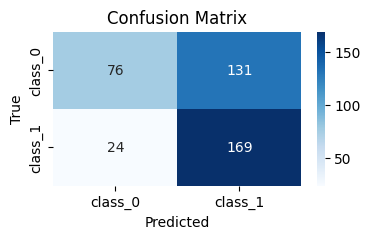

{'eval_loss': 0.6421260237693787, 'eval_accuracy': 0.6125, 'eval_f1': 0.587022715409875, 'eval_precision': 0.6651083333333334, 'eval_recall': 0.6125, 'eval_runtime': 2.2792, 'eval_samples_per_second': 175.503, 'eval_steps_per_second': 10.969, 'epoch': 0.5}
{'loss': 0.5127, 'grad_norm': 15.922797203063965, 'learning_rate': 2e-05, 'epoch': 1.0}


  0%|          | 0/25 [00:00<?, ?it/s]

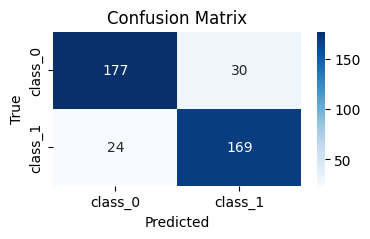

{'eval_loss': 0.35003700852394104, 'eval_accuracy': 0.865, 'eval_f1': 0.8650405162064826, 'eval_precision': 0.865470261756544, 'eval_recall': 0.865, 'eval_runtime': 2.2772, 'eval_samples_per_second': 175.653, 'eval_steps_per_second': 10.978, 'epoch': 1.0}
{'loss': 0.3896, 'grad_norm': 8.304340362548828, 'learning_rate': 3e-05, 'epoch': 1.5}


  0%|          | 0/25 [00:00<?, ?it/s]

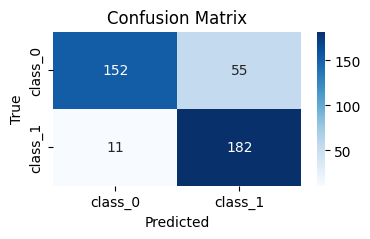

{'eval_loss': 0.3897097110748291, 'eval_accuracy': 0.835, 'eval_f1': 0.8336310496543056, 'eval_precision': 0.8531041132769019, 'eval_recall': 0.835, 'eval_runtime': 2.2693, 'eval_samples_per_second': 176.268, 'eval_steps_per_second': 11.017, 'epoch': 1.5}
{'loss': 0.3632, 'grad_norm': 9.04074764251709, 'learning_rate': 4e-05, 'epoch': 2.0}


  0%|          | 0/25 [00:00<?, ?it/s]

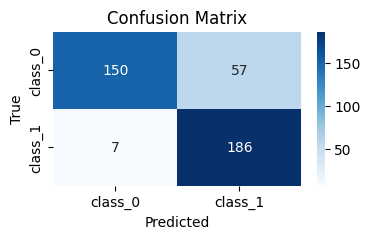

{'eval_loss': 0.39071524143218994, 'eval_accuracy': 0.84, 'eval_f1': 0.8381853009375945, 'eval_precision': 0.8637477392466777, 'eval_recall': 0.84, 'eval_runtime': 2.2653, 'eval_samples_per_second': 176.574, 'eval_steps_per_second': 11.036, 'epoch': 2.0}
{'loss': 0.2258, 'grad_norm': 2.530386447906494, 'learning_rate': 5e-05, 'epoch': 2.5}


  0%|          | 0/25 [00:00<?, ?it/s]

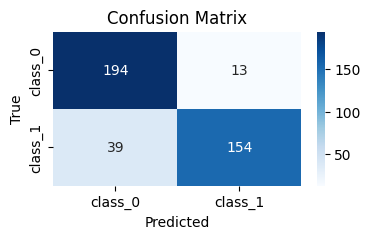

{'eval_loss': 0.4743695557117462, 'eval_accuracy': 0.87, 'eval_f1': 0.8691464646464645, 'eval_precision': 0.8758199480866594, 'eval_recall': 0.87, 'eval_runtime': 2.2465, 'eval_samples_per_second': 178.053, 'eval_steps_per_second': 11.128, 'epoch': 2.5}
{'loss': 0.2813, 'grad_norm': 23.197818756103516, 'learning_rate': 6e-05, 'epoch': 3.0}


  0%|          | 0/25 [00:00<?, ?it/s]

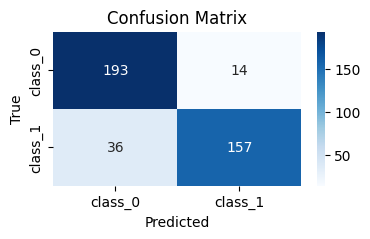

{'eval_loss': 0.4068077802658081, 'eval_accuracy': 0.875, 'eval_f1': 0.8743761971972981, 'eval_precision': 0.8791433642329989, 'eval_recall': 0.875, 'eval_runtime': 2.28, 'eval_samples_per_second': 175.438, 'eval_steps_per_second': 10.965, 'epoch': 3.0}
{'loss': 0.1413, 'grad_norm': 6.337376117706299, 'learning_rate': 7e-05, 'epoch': 3.5}


  0%|          | 0/25 [00:00<?, ?it/s]

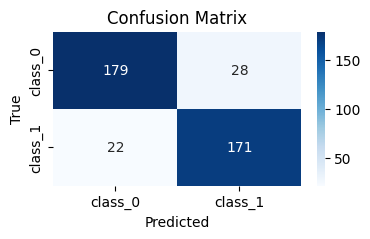

{'eval_loss': 0.4182993769645691, 'eval_accuracy': 0.875, 'eval_f1': 0.8750375150060024, 'eval_precision': 0.875468761719043, 'eval_recall': 0.875, 'eval_runtime': 2.2944, 'eval_samples_per_second': 174.341, 'eval_steps_per_second': 10.896, 'epoch': 3.5}
{'loss': 0.2183, 'grad_norm': 12.449926376342773, 'learning_rate': 8e-05, 'epoch': 4.0}


  0%|          | 0/25 [00:00<?, ?it/s]

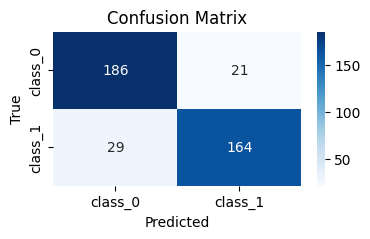

{'eval_loss': 0.3727019429206848, 'eval_accuracy': 0.875, 'eval_f1': 0.8748620828004715, 'eval_precision': 0.8754274041483344, 'eval_recall': 0.875, 'eval_runtime': 2.3157, 'eval_samples_per_second': 172.735, 'eval_steps_per_second': 10.796, 'epoch': 4.0}
{'loss': 0.1741, 'grad_norm': 17.93590545654297, 'learning_rate': 9e-05, 'epoch': 4.5}


  0%|          | 0/25 [00:00<?, ?it/s]

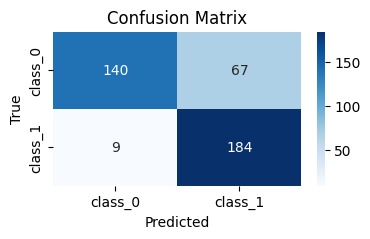

{'eval_loss': 0.708728015422821, 'eval_accuracy': 0.81, 'eval_f1': 0.8069323818200224, 'eval_precision': 0.8399467900211235, 'eval_recall': 0.81, 'eval_runtime': 2.3053, 'eval_samples_per_second': 173.512, 'eval_steps_per_second': 10.845, 'epoch': 4.5}
{'loss': 0.2168, 'grad_norm': 36.19648361206055, 'learning_rate': 0.0001, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

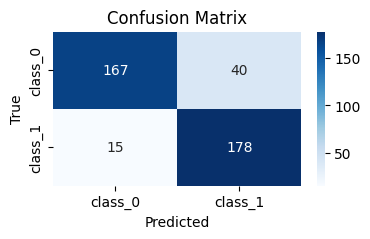

{'eval_loss': 0.6084368228912354, 'eval_accuracy': 0.8625, 'eval_f1': 0.8622634930165938, 'eval_precision': 0.868816791007158, 'eval_recall': 0.8625, 'eval_runtime': 2.2225, 'eval_samples_per_second': 179.977, 'eval_steps_per_second': 11.249, 'epoch': 5.0}
{'loss': 0.1635, 'grad_norm': 58.87054443359375, 'learning_rate': 9e-05, 'epoch': 5.5}


  0%|          | 0/25 [00:00<?, ?it/s]

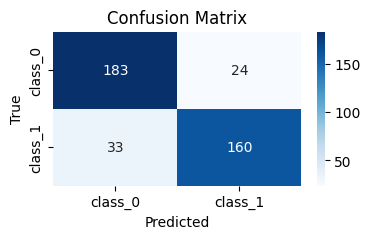

{'eval_loss': 0.4706823229789734, 'eval_accuracy': 0.8575, 'eval_f1': 0.8573150290648457, 'eval_precision': 0.8580027173913044, 'eval_recall': 0.8575, 'eval_runtime': 2.2698, 'eval_samples_per_second': 176.225, 'eval_steps_per_second': 11.014, 'epoch': 5.5}
{'loss': 0.1238, 'grad_norm': 0.12744759023189545, 'learning_rate': 8e-05, 'epoch': 6.0}


  0%|          | 0/25 [00:00<?, ?it/s]

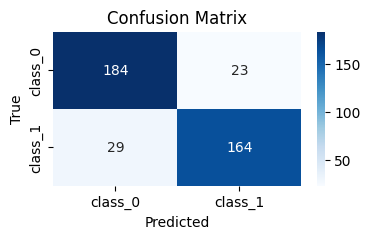

{'eval_loss': 0.6245092153549194, 'eval_accuracy': 0.87, 'eval_f1': 0.8699022556390977, 'eval_precision': 0.8701973337350304, 'eval_recall': 0.87, 'eval_runtime': 2.2849, 'eval_samples_per_second': 175.061, 'eval_steps_per_second': 10.941, 'epoch': 6.0}
{'loss': 0.0914, 'grad_norm': 2.418505907058716, 'learning_rate': 7e-05, 'epoch': 6.5}


  0%|          | 0/25 [00:00<?, ?it/s]

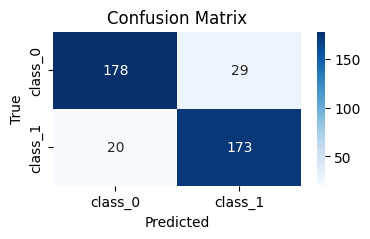

{'eval_loss': 0.5562235713005066, 'eval_accuracy': 0.8775, 'eval_f1': 0.877534458509142, 'eval_precision': 0.8784574707470747, 'eval_recall': 0.8775, 'eval_runtime': 2.2785, 'eval_samples_per_second': 175.553, 'eval_steps_per_second': 10.972, 'epoch': 6.5}
{'loss': 0.0714, 'grad_norm': 0.07402002066373825, 'learning_rate': 6e-05, 'epoch': 7.0}


  0%|          | 0/25 [00:00<?, ?it/s]

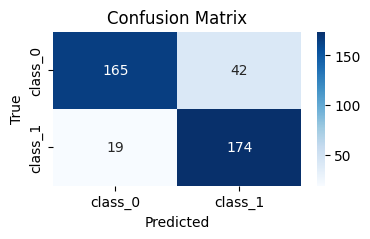

{'eval_loss': 0.7404082417488098, 'eval_accuracy': 0.8475, 'eval_f1': 0.8473026031928664, 'eval_precision': 0.8527430555555555, 'eval_recall': 0.8475, 'eval_runtime': 2.2684, 'eval_samples_per_second': 176.333, 'eval_steps_per_second': 11.021, 'epoch': 7.0}
{'loss': 0.0443, 'grad_norm': 0.016781721264123917, 'learning_rate': 5e-05, 'epoch': 7.5}


  0%|          | 0/25 [00:00<?, ?it/s]

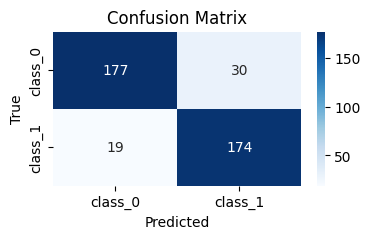

{'eval_loss': 0.7467665076255798, 'eval_accuracy': 0.8775, 'eval_f1': 0.8775252670462714, 'eval_precision': 0.8788783013205281, 'eval_recall': 0.8775, 'eval_runtime': 2.295, 'eval_samples_per_second': 174.295, 'eval_steps_per_second': 10.893, 'epoch': 7.5}
{'loss': 0.0203, 'grad_norm': 0.010820889845490456, 'learning_rate': 4e-05, 'epoch': 8.0}


  0%|          | 0/25 [00:00<?, ?it/s]

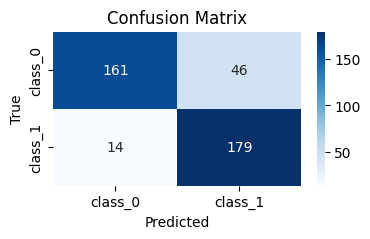

{'eval_loss': 0.9437015056610107, 'eval_accuracy': 0.85, 'eval_f1': 0.8494589042811694, 'eval_precision': 0.8599555555555556, 'eval_recall': 0.85, 'eval_runtime': 2.2738, 'eval_samples_per_second': 175.918, 'eval_steps_per_second': 10.995, 'epoch': 8.0}
{'loss': 0.0158, 'grad_norm': 0.008075405843555927, 'learning_rate': 3e-05, 'epoch': 8.5}


  0%|          | 0/25 [00:00<?, ?it/s]

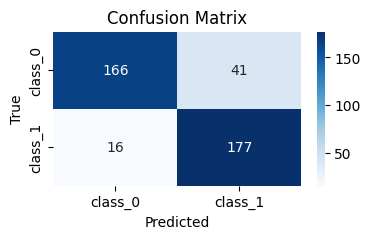

{'eval_loss': 0.922823429107666, 'eval_accuracy': 0.8575, 'eval_f1': 0.857254892762652, 'eval_precision': 0.8637600816614578, 'eval_recall': 0.8575, 'eval_runtime': 2.2537, 'eval_samples_per_second': 177.487, 'eval_steps_per_second': 11.093, 'epoch': 8.5}
{'loss': 0.0091, 'grad_norm': 0.006112010683864355, 'learning_rate': 2e-05, 'epoch': 9.0}


  0%|          | 0/25 [00:00<?, ?it/s]

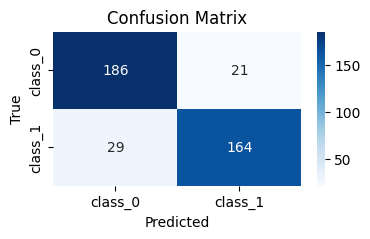

{'eval_loss': 0.8138800859451294, 'eval_accuracy': 0.875, 'eval_f1': 0.8748620828004715, 'eval_precision': 0.8754274041483344, 'eval_recall': 0.875, 'eval_runtime': 2.2146, 'eval_samples_per_second': 180.617, 'eval_steps_per_second': 11.289, 'epoch': 9.0}
{'loss': 0.0002, 'grad_norm': 0.006880055647343397, 'learning_rate': 1e-05, 'epoch': 9.5}


  0%|          | 0/25 [00:00<?, ?it/s]

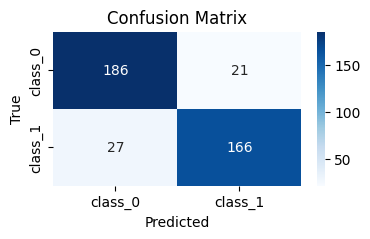

{'eval_loss': 0.8203967213630676, 'eval_accuracy': 0.88, 'eval_f1': 0.8799097744360901, 'eval_precision': 0.8802169164720945, 'eval_recall': 0.88, 'eval_runtime': 2.287, 'eval_samples_per_second': 174.904, 'eval_steps_per_second': 10.932, 'epoch': 9.5}
{'loss': 0.0014, 'grad_norm': 0.0063163284212350845, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/25 [00:00<?, ?it/s]

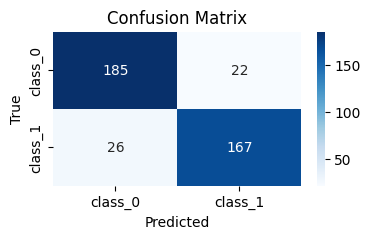

{'eval_loss': 0.8243629336357117, 'eval_accuracy': 0.88, 'eval_f1': 0.879945890428117, 'eval_precision': 0.8800682063241305, 'eval_recall': 0.88, 'eval_runtime': 2.2388, 'eval_samples_per_second': 178.664, 'eval_steps_per_second': 11.167, 'epoch': 10.0}
{'train_runtime': 338.6062, 'train_samples_per_second': 47.253, 'train_steps_per_second': 2.953, 'train_loss': 0.18769052819442003, 'epoch': 10.0}


/home/guest/.cache/pypoetry/virtualenvs/third-experments-xuKQSur9-py3.8/lib/python3.8/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

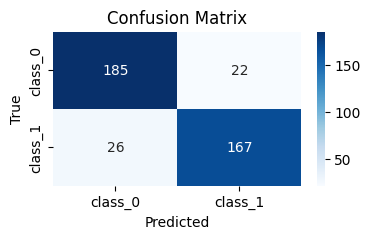

  0%|          | 0/50 [00:00<?, ?it/s]

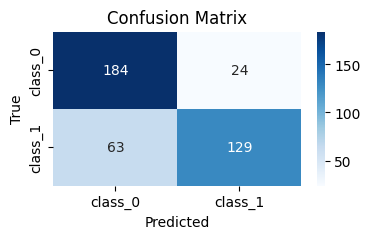

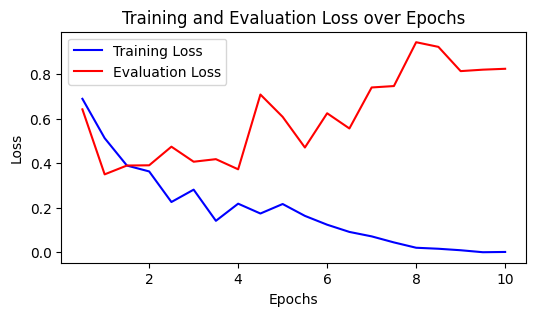

eval/accuracy,▁█▇▇████▆█▇██▇█▇▇████▅
eval/f1,▁█▇▇████▆█▇██▇█▇▇████▆
eval/loss,▃▁▁▁▂▁▁▁▄▃▂▃▂▄▄▅▅▄▄▄▄█
eval/precision,▁█▇▇████▇█▇██▇█▇▇████▅
eval/recall,▁█▇▇████▆█▇██▇█▇▇████▅
eval/runtime,▂▂▂▂▂▂▃▃▃▁▂▂▂▂▃▂▂▁▂▁█▇
eval/samples_per_second,▇▇▇▇▇▇▆▆▆█▇▆▇▇▆▇▇█▆▇▁▂
eval/steps_per_second,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████▁▁▁
train/grad_norm,▂▃▂▂▁▄▂▂▃▅█▁▁▁▁▁▁▁▁▁


Evaluation Results for seed 100:
{'eval_accuracy': 0.88,
 'eval_f1': 0.879945890428117,
 'eval_loss': 0.8243629932403564,
 'eval_precision': 0.8800682063241305,
 'eval_recall': 0.88,
 'eval_runtime': 2.5791,
 'eval_samples_per_second': 155.091,
 'eval_steps_per_second': 19.386}
Test Results for seed 100:
{'eval_accuracy': 0.7825,
 'eval_f1': 0.779527950310559,
 'eval_loss': 1.3538830280303955,
 'eval_precision': 0.7920743034055726,
 'eval_recall': 0.7825,
 'eval_runtime': 2.5254,
 'eval_samples_per_second': 158.392,
 'eval_steps_per_second': 19.799}
************
Mean Evaluation Results:
{'eval_accuracy': 0.8675,
 'eval_f1': 0.8674781353271132,
 'eval_loss': 0.8887203335762024,
 'eval_precision': 0.8690299712533633,
 'eval_recall': 0.8675,
 'eval_runtime': 2.1903333333333332,
 'eval_samples_per_second': 198.433,
 'eval_steps_per_second': 24.804000000000002}
Mean Test Results:
{'eval_accuracy': 0.8099999999999999,
 'eval_f1': 0.808099645508331,
 'eval_loss': 1.2260111967722576,
 'eval_pr

In [4]:
seeds = [42, 10, 100]
project_name="SDA_testing_trainer"

adapter_name = "SDA_SG_invLora_stack"
mlm_adapter = "SDA_mlm_inv_G"
all_results = []
source_genre = 'books'
target_genre = 'electronics'
source_dataset, target_dataset = load_and_prepare_datasets(source_genre, target_genre, data_fraction=1)



for seed in seeds:
    eval_results, test_results = train_and_evaluate(project_name, seed, source_dataset, target_dataset, source_genre, target_genre, adapter_name, mlm_adapter)
    all_results.append((eval_results, test_results))
    print(f"Evaluation Results for seed {seed}:")
    pprint(eval_results)
    print(f"Test Results for seed {seed}:")
    pprint(test_results)

mean_eval_results = {key: np.mean([result[0][key] for result in all_results]) for key in all_results[0][0]}
mean_test_results = {key: np.mean([result[1][key] for result in all_results]) for key in all_results[0][1]}
print(f"************")
print(f"Mean Evaluation Results:")
pprint(mean_eval_results)
print(f"Mean Test Results:")
pprint(mean_test_results)
print(f"************")

# Plot the overall performance metrics
for metric in mean_eval_results:
    print(f"Mean Evaluation {metric}: {mean_eval_results[metric]:.4f}")
for metric in mean_test_results:
    print(f"Mean Test {metric}: {mean_test_results[metric]:.4f}")